## Overview

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#from fastaidev import *
#from fastaidev.vision import *
#from fastaidev.callbacks import *
#from fastaidev.metrics import *

#from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.metrics import *

from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
plt.style.use(['dark_background'])

## Paths

In [5]:
DATA_PATH = Config.data_path()/'competitions'
PATH = DATA_PATH/'diabetic-retinopathy-detection'
CSV_PATH = PATH/'trainLabels.csv'
META_PATH = PATH/'metadata.csv'

In [6]:
PATH.ls()[:5]

[PosixPath('/home/achen/.fastai/data/competitions/diabetic-retinopathy-detection/metadata.csv'),
 PosixPath('/home/achen/.fastai/data/competitions/diabetic-retinopathy-detection/sample.zip'),
 PosixPath('/home/achen/.fastai/data/competitions/diabetic-retinopathy-detection/sampleSubmission.csv.zip'),
 PosixPath('/home/achen/.fastai/data/competitions/diabetic-retinopathy-detection/trainLabels.csv'),
 PosixPath('/home/achen/.fastai/data/competitions/diabetic-retinopathy-detection/trainLabels.csv.zip')]

## EDA

In [7]:
df = pd.read_csv(CSV_PATH)

In [8]:
df.iloc[22:24]

,image,level
22,30_left,1
23,30_right,2


Every image should be taken independent regardless of its id or left and right

In [9]:
df['patient'] = df.image.map(lambda x: x.split('_')[0])
df['eye'] = df.image.map(lambda x: 1 if x.split('_')[1]=='left' else 0)

In [10]:
df.head()

,image,level,patient,eye
0,10_left,0,10,1
1,10_right,0,10,0
2,13_left,0,13,1
3,13_right,0,13,0
4,15_left,1,15,1


In [11]:
df.to_feather(META_PATH)

In [12]:
import feather
df = feather.read_dataframe(META_PATH)

In [13]:
level_sum = df.groupby(['level'], as_index=False).count()
level_sum

,level,image,patient,eye
0,0,25810,25810,25810
1,1,2443,2443,2443
2,2,5292,5292,5292
3,3,873,873,873
4,4,708,708,708


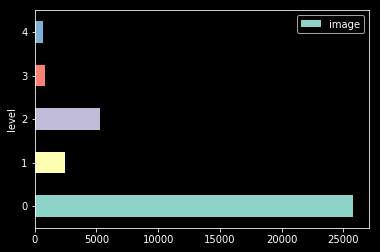

In [14]:
level_sum.plot('level','image','barh');

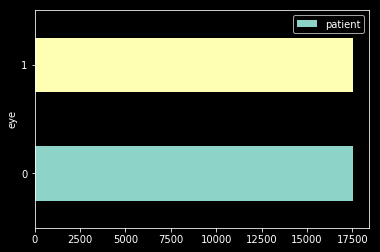

In [15]:
eye_sum = df.groupby(['eye'], as_index=False).count()
eye_sum.plot('eye', 'patient','barh');

In [16]:
id2label = {
    0 : "No DR",
    1 : "Mild",
    2 : "Moderate",
    3 : "Severe",
    4 : "Proliferative DR"}

In [17]:
label2id = {v:k for k,v in id2label.items()}; label2id

{'No DR': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Proliferative DR': 4}

In [18]:
strat = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=66)

In [19]:
train_ids,test_ids = next(iter(strat.split(df.image, df.level)))
train_ids.shape, test_ids.shape

((28100,), (7026,))

In [20]:
df['is_test'] = 0
df.loc[test_ids,'is_test'] = 1

In [21]:
df.head()

,image,level,patient,eye,is_test
0,10_left,0,10,1,0
1,10_right,0,10,0,1
2,13_left,0,13,1,1
3,13_right,0,13,0,0
4,15_left,1,15,1,1


In [22]:
df.to_csv(PATH/'stratTrainLabels.csv', index=False)

In [23]:
df_test = pd.read_csv(PATH/'stratTrainLabels.csv')

## Data Pipeline

In [24]:
#db0 = ImageItemList.from_csv(PATH,'stratTrainLabels.csv', folder='train_512', suffix='.jpeg')

In [25]:
#db1 = db0.split_from_df(col='is_test')

In [26]:
#db2 = db1.label_from_df(cols='level')

### Decide the `tfms`

In [27]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=180,
                      xtra_tfms=rand_resize_crop(224, max_scale=2, ratios=(1/1.6, 1.6)))

In [ ]:
def get_ex(): return open_image(src.train.items[0])

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

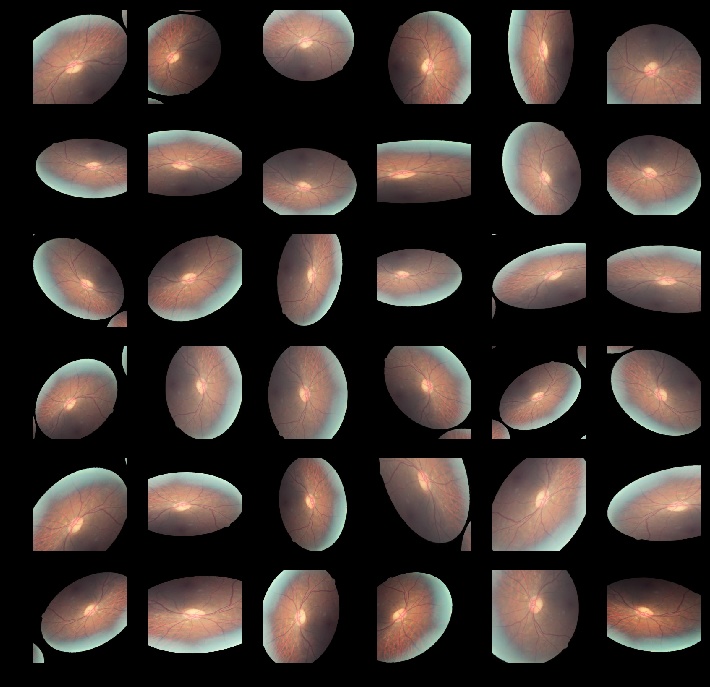

In [ ]:
plots_f(6, 6, 12, 12, size=224)

### Load data

In [30]:
sz,bs = 224,64
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=180, 
                      xtra_tfms=rand_resize_crop(sz, max_scale=2, ratios=(1/1.6, 1.6)))

In [31]:
src = (ImageItemList.from_csv(PATH,'stratTrainLabels.csv', folder='train', suffix='.jpeg')
       .split_from_df(col='is_test')
       .label_from_df(cols='level')
       .add_test_folder(test_folder='test'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/achen/.fastai/data/competitions/diabetic-retinopathy-detection/train/10_left.jpeg'

In [ ]:
data = (src.transform(tfms=tfms, size=sz)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

### Convert

In [ ]:
#folder,size = "test",512 
folder,size = "train",512
files = list((PATH/f'{folder}').glob('*.jpeg')); files[:5]

[PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/train/11163_left.jpeg'),
 PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/train/35788_left.jpeg'),
 PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/train/21602_right.jpeg'),
 PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/train/6376_right.jpeg'),
 PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/train/14115_left.jpeg')]

In [ ]:
def convert2size(fname,i):
    save_name = str(fname).replace(f'{folder}',f'{folder}_{size}')
    Path(save_name).parent.mkdir(exist_ok=True, parents=True)
    open_image(fname).resize((-1,size,size)).save(save_name)

In [ ]:
parallel(convert2size,files)

## Sanity Check

In [ ]:
data.sanity_check()

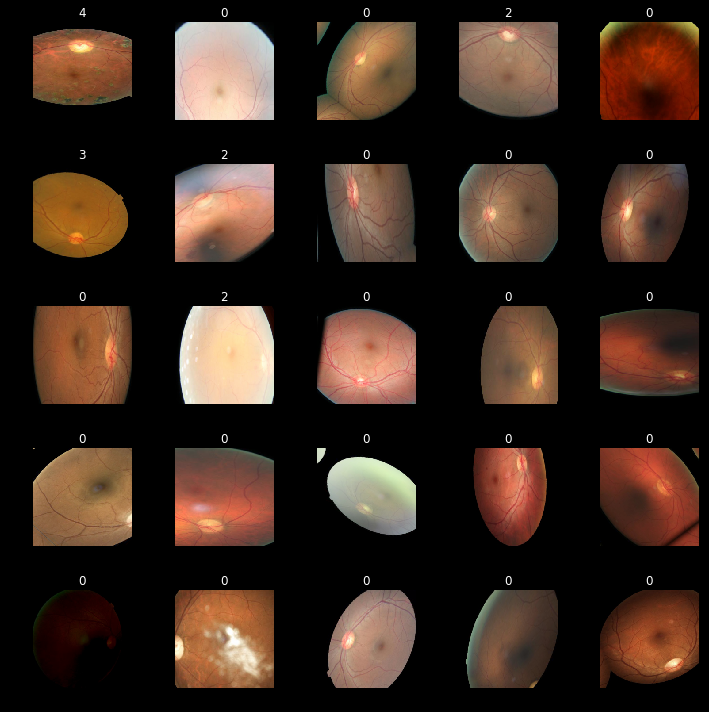

In [ ]:
data.show_batch(rows=5, figsize=(10,10))

## Train

### Focal Loss 

The focal loss is described in ["Focal Loss for Dense Object Detection"](https://arxiv.org/pdf/1708.02002.pdf) and is simply a modified version of binary cross entropy in which the loss for confidently correctly classifed labels is scaled down, so that the network focuses more on incorrect and low confidence labels than on increasing its confidence in the already correct labels. 

In the image below, you can see the ordinary binary cross entropy loss function as the top line and different variants of focal loss (focal loss is parameterized by gamma, gamma=0 is the same as binary cross entropy). We can clearly see that focal loss places much less importance on examples for which the confidence is higher than ordinary BCE.

In [ ]:
#export
class FocalLoss(nn.Module):
    def __init__(self,c:int,gamma:float=2.0,alpha:float=.25):
        super().__init__()
        self.c,self.gamma,self.alpha = c,gamma,alpha
        
    def get_weight(self,x,t):
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = self.alpha*t + (1-self.alpha)*(1-t)
        #import ipdb; ipdb.set_trace()
        return w * (1-pt).pow(self.gamma)
         
    def get_onehot(self,t):
         return torch.eye(self.c)[t.detach()]
        
    def forward(self, input, target, reduction='mean', **kwargs):
        #import ipdb; ipdb.set_trace()
        target = self.get_onehot(target).cuda()
        input = input.cuda()
        
        assert target.size() == input.size()
        
        ws = self.get_weight(input,target).detach()
        #import ipdb; ipdb.set_trace()
        loss = F.binary_cross_entropy_with_logits(input,target,ws,reduction='none')
        
        return loss.mean() if reduction=='mean' else loss.mean(dim=1)
    
#class FocalLoss(nn.Module):
#    def __init__(self,c:int,gamma:float=2.0):
#        super().__init__()
#        self.c,self.gamma = c,gamma
#        
#    def get_onehot(self,t):
#         return torch.eye(self.c)[t.data]
#        
#    def forward(self, input, target):
#        # Inspired by the implementation of binary_cross_entropy_with_logits
#        target = self.get_onehot(target).cuda()
#        
#        if not (target.size() == input.size()):
#            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))
#
#        max_val = (-input).clamp(min=0)
#        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()
#
#        # This formula gives us the log sigmoid of 1-p if y is 0 and of p if y is 1
#        invprobs = F.logsigmoid(-input * (target * 2 - 1))
#        loss = (invprobs * self.gamma).exp() * loss
#        
#        return loss.sum(dim=1).mean()

In [ ]:
arch = models.resnet50
learn = create_cnn(data, arch, metrics=accuracy)

In [ ]:
learn.loss_func = FocalLoss(data.c)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


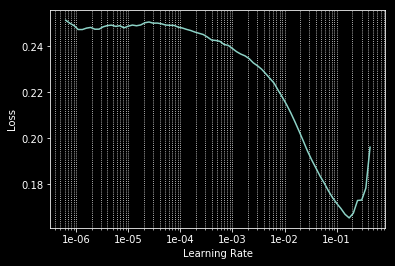

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
lr=slice(3e-2)

In [ ]:
learn.fit_one_cycle(10,lr)

epoch,train_loss,valid_loss,accuracy
1,0.030820,0.030023,0.736692
2,0.029315,0.028437,0.746371
3,0.029394,0.036743,0.748221
4,0.029128,0.028777,0.747225
5,0.027361,0.029561,0.757188
6,0.026716,0.031479,0.756618
7,0.026041,0.053051,0.766866
8,0.025143,0.026513,0.779675
9,0.024420,0.026414,0.782380
10,0.024208,0.026022,0.781526


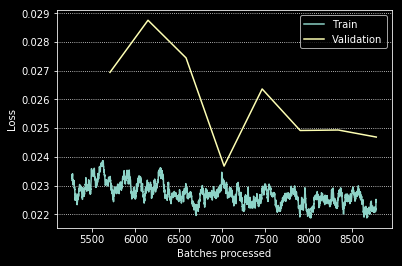

In [ ]:
learn.recorder.plot_losses(last=8)
plt.gca().grid(axis='y', which='both', linestyle=':')

In [ ]:
learn.save('01202019-stage-1-frz-eps10-lr3en2-focal-aug')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


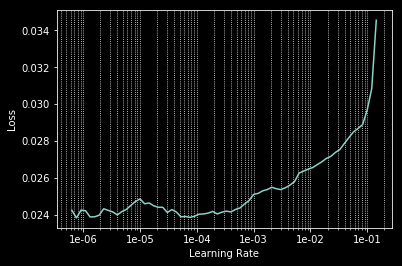

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
lrs = slice(2e-6,2e-4)

In [ ]:
learn.callback_fns.append(partial(SaveModelCallback, name='01202019-stage-2-unfrz-eps16-focal-aug-best'))

In [ ]:
learn.fit_one_cycle(20,lrs)

epoch,train_loss,valid_loss,accuracy
1,0.024122,0.026040,0.784799
2,0.023917,0.029796,0.783661
3,0.023937,0.024561,0.785369
4,0.024354,0.024868,0.781241
5,0.024238,0.025470,0.783518
6,0.024497,0.025293,0.773555
7,0.024031,0.024006,0.786650
8,0.023764,0.024157,0.786080
9,0.023252,0.031534,0.779960
10,0.023576,0.028849,0.789212


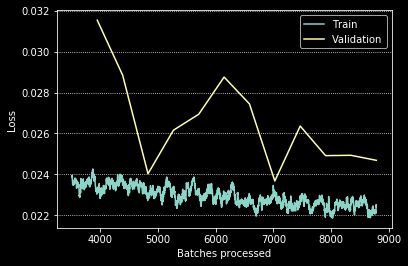

In [ ]:
learn.recorder.plot_losses(12)
plt.gca().grid(axis='y', which='both', linestyle=':')

In [ ]:
learn.load('01202019-stage-2-unfrz-eps16-focal-aug-best');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

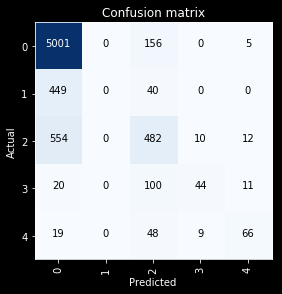

In [ ]:
interp.plot_confusion_matrix()

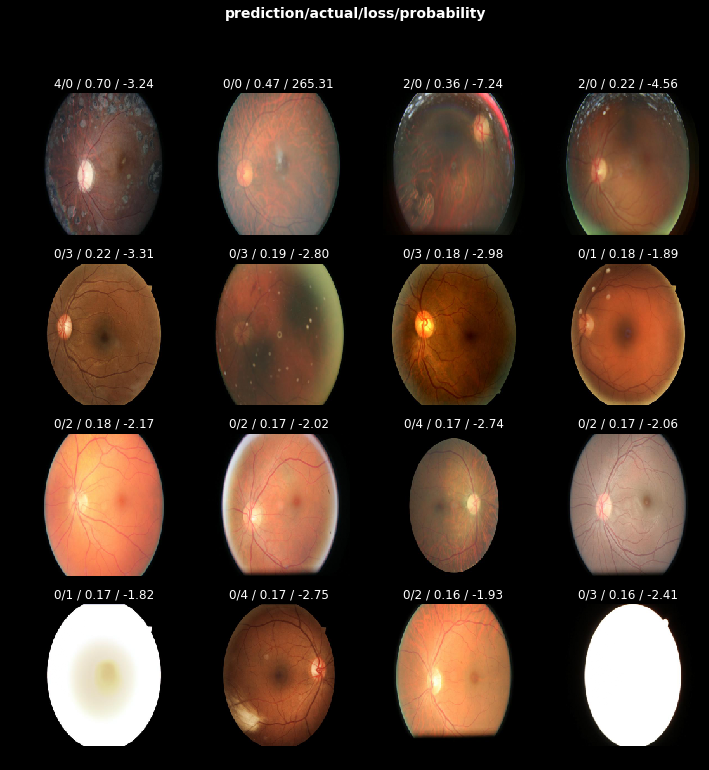

In [ ]:
interp.plot_top_losses(k=16)

## Progressive Resize

In [ ]:
learn.load('01202019-stage-2-unfrz-eps16-focal-aug-best');

In [ ]:
sz,bs = 384,32
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=180, 
                      xtra_tfms=rand_resize_crop(sz, max_scale=2, ratios=(1/1.6, 1.6)))

In [ ]:
data = (src.transform(tfms=tfms, size=sz)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn.data = data

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


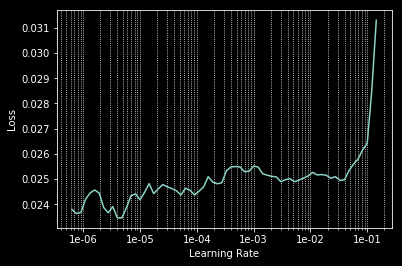

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
lrs=slice(2e-3)

In [ ]:
#learn.callback_fns.pop(1)
learn.callback_fns.append(partial(SaveModelCallback, name='01202019-stage-3-frz-384-eps10-focal-aug-best'))

In [ ]:
learn.fit_one_cycle(8,lrs)

epoch,train_loss,valid_loss,accuracy
1,0.023832,0.052838,0.799744
2,0.023591,0.076680,0.805437
3,0.023128,0.045022,0.805010
4,0.023725,0.037204,0.806149
5,0.023113,0.045082,0.806433
6,0.021702,0.062158,0.805722
7,0.022415,0.045062,0.809422
8,0.022132,0.031594,0.808995


In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


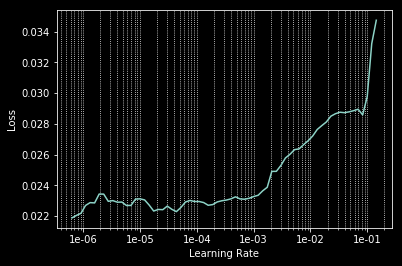

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
lrs=slice(2e-6, 2e-3/5)

In [ ]:
learn.callback_fns.pop(1)
learn.callback_fns.append(partial(SaveModelCallback, name='01202019-stage-4-unfrz-384-eps16-focal-aug-best'))

In [ ]:
learn.fit_one_cycle(16,lrs)

epoch,train_loss,valid_loss,accuracy
1,0.022326,0.033452,0.809564
2,0.022779,0.034295,0.804298
3,0.022718,0.107619,0.801452
4,0.023311,0.031172,0.801309
5,0.022848,0.032020,0.802021
6,0.022385,0.037803,0.805010
7,0.021926,0.025861,0.805722
8,0.021996,0.047332,0.806718
9,0.021790,0.043753,0.814119
10,0.021058,0.056407,0.811557


In [ ]:
learn.load('01202019-stage-4-unfrz-384-eps16-focal-aug-best');

In [ ]:
sz,bs = 512,16
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=180, 
                      xtra_tfms=rand_resize_crop(sz, max_scale=2, ratios=(1/1.6, 1.6)))

In [ ]:
data = (src.transform(tfms=tfms, size=sz)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn.data = data

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


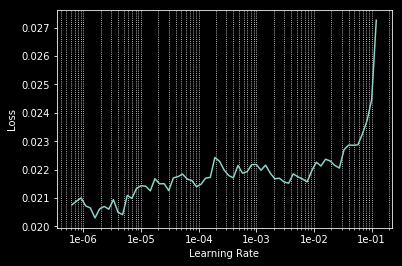

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
lrs = slice(2e-3)

In [ ]:
learn.callback_fns.pop(1)
learn.callback_fns.append(partial(SaveModelCallback, name='01202019-stage-5-unfrz-512-eps10-focal-aug-best'))

In [ ]:
learn.fit_one_cycle(10,lrs)

epoch,train_loss,valid_loss,accuracy
1,0.022046,0.058821,0.812553
2,0.021831,0.112495,0.810561
3,0.023992,0.076843,0.813123
4,0.022297,0.069645,0.812411
5,0.020702,0.056539,0.809280
6,0.021837,0.059989,0.820381
7,0.022441,0.074881,0.815969
8,0.020365,0.051138,0.817962
9,0.021492,0.051449,0.817535
10,0.021769,0.203863,0.816539


In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


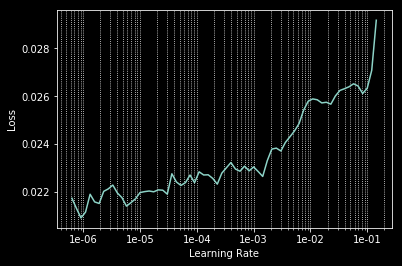

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
lrs=slice(2e-6, 2e-3/5)

In [ ]:
learn.callback_fns.pop(1)
learn.callback_fns.append(partial(SaveModelCallback, name='01202019-stage-6-unfrz-512-eps20-focal-aug-best'))

In [ ]:
learn.fit_one_cycle(20,lrs)

epoch,train_loss,valid_loss,accuracy
1,0.021020,0.071394,0.818246
2,0.021098,0.069232,0.817393
3,0.021784,0.139831,0.807857
4,0.021480,0.082978,0.804725
5,0.022318,0.043136,0.807145
6,0.022297,0.078208,0.812838
7,0.022193,0.092335,0.808568
8,0.023549,0.031223,0.814261
9,0.021634,0.026926,0.813834
10,0.022530,0.073325,0.816112


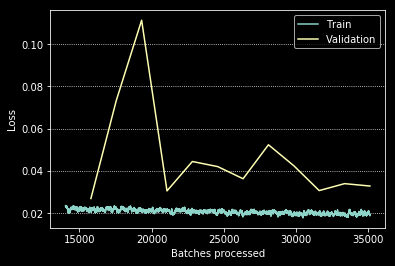

In [ ]:
learn.recorder.plot_losses(12)
plt.gca().grid(axis='y', which='both', linestyle=':')

## Interpret

In [ ]:
learn.load('01202019-stage-6-unfrz-512-eps20-focal-aug-best');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

Before and after applying Progressive Resizing

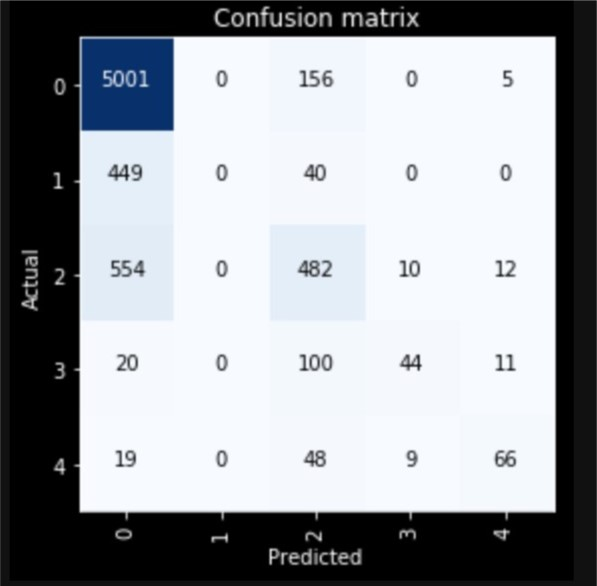

In [ ]:
from IPython.display import Image as displayim
PATH = "./before_prog_resize.jpg"
displayim(filename = PATH, width=290, height=290)

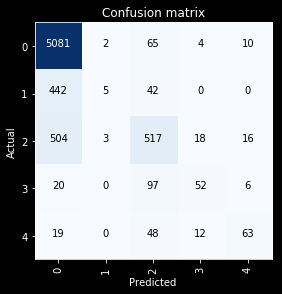

In [ ]:
interp.plot_confusion_matrix()

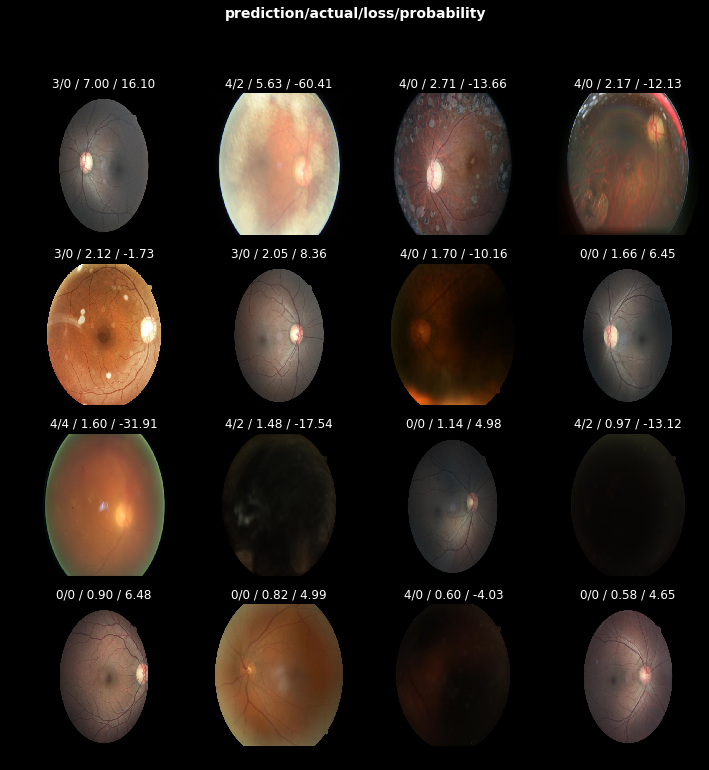

In [ ]:
interp.plot_top_losses(k=16)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, tta=True)

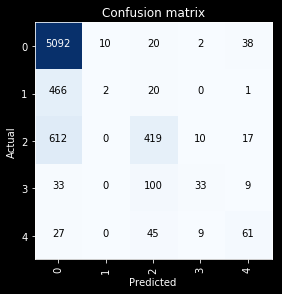

In [ ]:
interp.plot_confusion_matrix()

TTA is making it worse. Note this TTA is class `ClassificationInterpretation` is pretty standard with `scale=1.35`. I will play with the param at inference stage to see how it works.

## Make Prediction 

In [ ]:
learn.load('01202019-stage-6-unfrz-512-eps20-focal-aug-best');

In [ ]:
preds = learn.get_preds(DatasetType.Test)

In [ ]:
p = preds[0].argmax(dim=1).numpy()
d = { fn.stem : p[i] for i,fn in enumerate(progress_bar(learn.data.test_ds.x.items)) }

In [ ]:
sub = pd.DataFrame.from_dict(d, orient='index')
sub.index.names = ['image']
sub.columns = ['level']
sub.to_csv(PATH/'submission.csv')

## Version Control

- ~~v1.0~~:
    - [x] Pre-process the original images to 512x512
    - [x] Transfer learning using imageneti-pretrained resnet50
- ~~v1.1~~: Implement Focal loss to weigh on the minor label

- v1.2
    - [x] Progressive resizing: sz,bs = 224,64 -> 384,32 -> 512,16
    - [ ] Clean up the bad images or manually augment them
    - [ ] Try [`MixedPrecision`](https://docs.fast.ai/callbacks.fp16.html) inspired by this [post](https://forums.fast.ai/t/mixed-precision-training-still-kills-the-kernel-in-v100-with-cuda-10-0-and-latest-driver/30214).

In [ ]:
!kaggle competitions submit -c diabetic-retinopathy-detection -f "{PATH}/submission.csv" -m "01212019_sanity_check_1"

100%|████████████████████████████████████████| 693k/693k [00:10<00:00, 69.0kB/s]
Successfully submitted to Diabetic Retinopathy Detection

## EON